In [30]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')


Let's get our appearance data from before.

In [11]:

apps = pd.read_csv('sponge_app_df.csv').drop(columns = ['Unnamed: 0'])

Now, we're going to perform some clustering on the appearances to see if we can generate any interesting/useful insights. Let's first see how many principal components is ideal here. We like to look for an inflection point in the scree plot to determine this.

Text(0, 0.5, 'Variance explained')

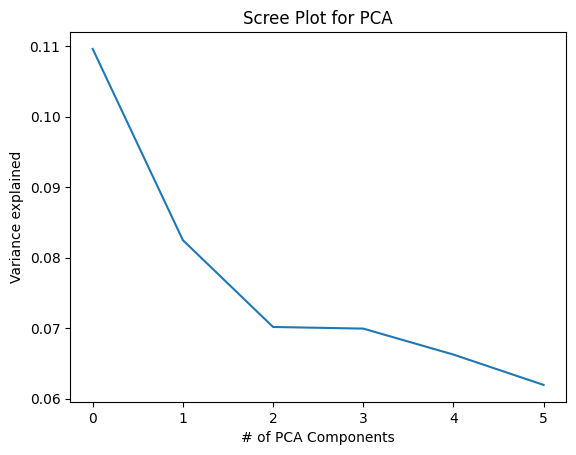

In [21]:
pca = PCA(n_components=6)
X_pca = pca.fit_transform(scale(X))
sns.lineplot(pca.explained_variance_ratio_)
plt.title('Scree Plot for PCA')
plt.xlabel('# of PCA Components')
plt.ylabel('Variance explained')

The inflection occurs at 2. We'd need double the components from there to really gain any new information, so we will settle on two principal components. Now let's get to clustering!

In [22]:
# create X 
X = apps.drop(columns = ['Episode #', 'Title', 'Rating', 'Script','allchars'])

# pipe the data
pipe = Pipeline([
   # ('fillwith1', SimpleImputer(strategy="constant", fill_value=1)),
    ('scale',StandardScaler()),
    ('pca', PCA(n_components=2,random_state=42)),
    ('cluster', AgglomerativeClustering(n_clusters=2) ),
])

# create predictions
y_pred = pipe.fit_predict(X)

Now, we can combine it together to see how each cluster performs.

In [23]:
merged = pd.concat([apps,pd.DataFrame(y_pred, columns = ['pred'])], axis = 1)
display(merged.groupby(by = 'pred').mean())
display(merged.groupby(by = 'pred').median())

,Episode #,Rating,SpongeBob,Mr. Krabs,Squidward,Patrick,French Narrator,Gary,Sandy,All,...,Narrator,Harold,Plankton,Karen,SpongeBob and Patrick,Mrs. Puff,Fred,Pearl,Both,Nat
pred,,,,,,,,,,,,,,,,,,,,,
0,225.020958,7.279940,1.000000,0.619760,0.757485,0.745509,0.095808,0.302395,0.266467,0.095808,...,0.251497,0.188623,0.125749,0.014970,0.266467,0.128743,0.170659,0.095808,0.107784,0.110778
1,306.120690,7.151724,0.948276,0.896552,0.706897,0.258621,0.189655,0.120690,0.120690,0.051724,...,0.155172,0.068966,0.948276,0.862069,0.017241,0.068966,0.120690,0.103448,0.034483,0.120690


,Episode #,Rating,SpongeBob,Mr. Krabs,Squidward,Patrick,French Narrator,Gary,Sandy,All,...,Narrator,Harold,Plankton,Karen,SpongeBob and Patrick,Mrs. Puff,Fred,Pearl,Both,Nat
pred,,,,,,,,,,,,,,,,,,,,,
0,205.0,7.2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,332.5,7.1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Cluster 1 looks to be slightly worse than Cluster 0. Let's take a look at that some more. The averages of these should resemble the percentage of episodes said character appeared in (because it's 1 if appeared, 0 if not), so let's actually take a look at the difference between the two groups to assess our most prominent character differences between the two clusters.

NOTE: This is group that performs better - group that performs worse, so note that when looking at these ratios.

In [29]:

apps_diffs = pd.DataFrame(((merged.query('pred == 0').
    drop(columns = ['Episode #', 'Title', 'Rating', 'pred'])).mean() - \
(merged.query('pred == 1').
    drop(columns = ['Episode #', 'Title', 'Rating', 'pred'])).mean()).round(3),
    columns = ['Difference in Appearance %'])


display(apps_diffs.sort_values(by = 'Difference in Appearance %',
                               ascending = True).head(3))
display(apps_diffs.sort_values(by = 'Difference in Appearance %',
                               ascending = False).head(4))

,Difference in Appearance %
Karen,-0.847
Plankton,-0.823
Mr. Krabs,-0.277


,Difference in Appearance %
Patrick,0.487
SpongeBob and Patrick,0.249
Gary,0.182
Sandy,0.146


The clustering algorithm saw the largest negative difference in appearance percentage in Karen and Plankton, and the largest difference in appearance with Patrick and SpongeBob and Patrick together.

What's interesting here is that the top 3 negative differences in appearance rate are characters primarily associated with Krusty Krab episodes, and the highest difference in appearance rate are chracters primarily associated with episodes that would typically occur in the Home setting.

The agglomerative clustering actually picked up on these groupings! Note that this clustering method isn't always 100% reliable for boolean data such as this, so we should proceed with caution from here. 

This allows us to reassess if the setting of the episode is a key factor in the rating. This time, our groups are actually made for us instead of us having to create our own group parameters for the setting.

In [44]:
print('The p-value for rating difference between groups is %s'%
round(stats.ttest_ind(merged['Rating'][merged['pred'] == 1],
                merged['Rating'][merged['pred'] == 0])[1],3)
)

The p-value for rating difference between groups is 0.449


From this, we have found that the setting truly doesn't make a difference in the rating of the episode. 